# Step 1.1) Load Libraries¶
Import all necessary libraries for the project.

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import re  
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingRegressor


# Step 1.2) Load the dataset
Load the dataset and display the first few rows.

In [35]:
df = pd.read_csv("housing.csv")
df.head()
#df.shape

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price,Address
0,79545.45857,5.682861,7.009188,4.09,23086.80050,1.059034e+06,"208 Michael Ferry Apt. 674\nLaurabury, NE 3701..."
1,79248.64245,6.002900,6.730821,3.09,40173.07217,1.505891e+06,"188 Johnson Views Suite 079\nLake Kathleen, CA..."
2,61287.06718,5.865890,8.512727,5.13,36882.15940,1.058988e+06,"9127 Elizabeth Stravenue\nDanieltown, WI 06482..."
3,63345.24005,7.188236,5.586729,3.26,34310.24283,1.260617e+06,USS Barnett\nFPO AP 44820
4,59982.19723,5.040555,7.839388,4.23,26354.10947,6.309435e+05,USNS Raymond\nFPO AE 09386


In [36]:
# Step 1: Parse the Address Column
# Your addresses are multi-line strings. We'll break them into: Street,City,State,ZIP Code
# Function to parse city, state, and ZIP from the second line of address
def parse_address(addr):
    # Extract the second line (usually contains city, state ZIP)
    lines = addr.split('\n')
    if len(lines) < 2:
        return pd.Series([None, None, None])
    
    line2 = lines[1]
    
    # Try extracting with regex
    match = re.search(r'(?P<city>.+),\s+(?P<state>[A-Z]{2})\s+(?P<zip>\d{5})', line2)
    if match:
        return pd.Series([match.group('city'), match.group('state'), match.group('zip')])
    else:
        return pd.Series([None, None, None])

df[['City', 'State', 'ZipCode']] = df['Address'].apply(parse_address)
#Step 2: Encode the Categorical Features
#Once extracted City, State, and ZipCode, convert them for modeling:

# Encode State and City
le_state = LabelEncoder()
df['State_encoded'] = le_state.fit_transform(df['State'].astype(str))

le_city = LabelEncoder()
df['City_encoded'] = le_city.fit_transform(df['City'].astype(str))

# Optionally convert ZipCode to numeric or categorical:
df['ZipCode'] = df['ZipCode'].astype(str)
df['Zip3'] = df['ZipCode'].str[:3]  # First 3 digits (area code style)
df['Zip3_encoded'] = LabelEncoder().fit_transform(df['Zip3'])


# Step 2.1) Descriptive Statistics
Generate summary statistics for the dataset.

In [37]:
summary = df.describe()
print(summary)
print(df.dtypes)


       Avg. Area Income  Avg. Area House Age  Avg. Area Number of Rooms  \
count       5000.000000          5000.000000                5000.000000   
mean       68583.108984             5.977222                   6.987792   
std        10657.991214             0.991456                   1.005833   
min        17796.631190             2.644304                   3.236194   
25%        61480.562390             5.322283                   6.299250   
50%        68804.286405             5.970429                   7.002902   
75%        75783.338665             6.650808                   7.665871   
max       107701.748400             9.519088                  10.759588   

       Avg. Area Number of Bedrooms  Area Population         Price  \
count                   5000.000000      5000.000000  5.000000e+03   
mean                       3.981330     36163.516039  1.232073e+06   
std                        1.234137      9925.650114  3.531176e+05   
min                        2.000000       17

# Step 2.2) Data Visualizations
Visualize the data to identify patterns and relationships.

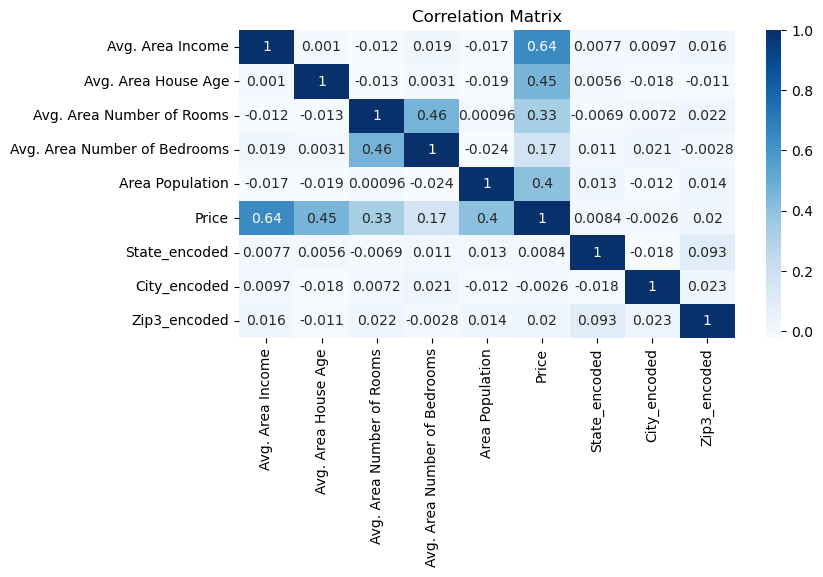

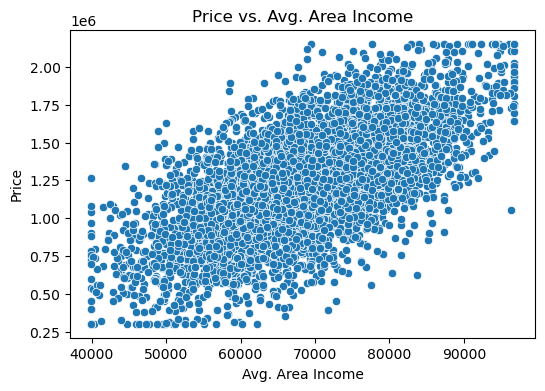

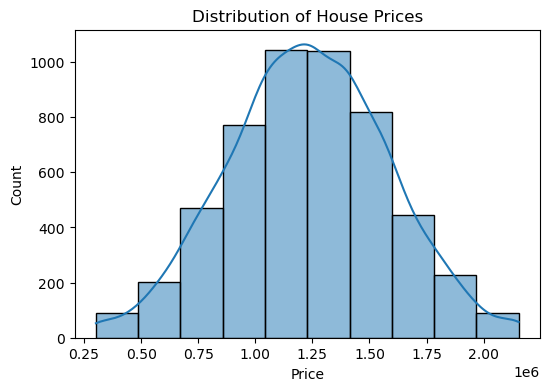

In [ ]:

df_numeric = df[[
    'Avg. Area Income',
    'Avg. Area House Age',
    'Avg. Area Number of Rooms',
    'Avg. Area Number of Bedrooms',
    'Area Population',
    'Price',
    'State_encoded',     
    'City_encoded',        
    'Zip3_encoded'          
]]

# Heatmap - 
plt.figure(figsize=(8, 4))
sns.heatmap(df_numeric.corr(), annot=True, cmap='Blues')
plt.title("Correlation Matrix")
plt.show()

# Scatterplot
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Avg. Area Income', y='Price', data=df_numeric)
plt.title("Price vs. Avg. Area Income")
plt.show()

# Histogram
plt.figure(figsize=(6, 4))
sns.histplot(df_numeric['Price'], bins=10, kde=True)
plt.title("Distribution of House Prices")
plt.show()


# If your dataset has missing values, visualize them:
plt.figure(figsize=(10, 4))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()




# Step 3.1 Clean Data
 Handle Missing Value

In [38]:
df.isnull().sum()


Avg. Area Income                  0
Avg. Area House Age               0
Avg. Area Number of Rooms         0
Avg. Area Number of Bedrooms      0
Area Population                   0
Price                             0
Address                           0
City                            514
State                           514
ZipCode                           0
State_encoded                     0
City_encoded                      0
Zip3                              0
Zip3_encoded                      0
dtype: int64

In [39]:
#Best Idea: Use ZipCode to Fill Missing City and State

#Since each ZipCode is generally tied to a unique City and State, I can use ZipCode to look up the missing values.

In [40]:
# Create reference from non-null rows
zip_to_city_state = df[df['City'].notnull()][['ZipCode', 'City', 'State']].drop_duplicates()
# Merge to fill missing city/state
df = df.merge(zip_to_city_state, on='ZipCode', how='left', suffixes=('', '_ref'))

# Fill only where original is null
df['City'] = df['City'].fillna(df['City_ref'])
df['State'] = df['State'].fillna(df['State_ref'])

# Drop the temporary columns
df.drop(['City_ref', 'State_ref'], axis=1, inplace=True)
#If some ZipCodes don’t help recover City/State, use mode imputation:

df['City'] = df['City'].fillna(df['City'].mode()[0])
df['State'] = df['State'].fillna(df['State'].mode()[0])


In [41]:
df.isnull().sum()


Avg. Area Income                0
Avg. Area House Age             0
Avg. Area Number of Rooms       0
Avg. Area Number of Bedrooms    0
Area Population                 0
Price                           0
Address                         0
City                            0
State                           0
ZipCode                         0
State_encoded                   0
City_encoded                    0
Zip3                            0
Zip3_encoded                    0
dtype: int64

# Handle Outliers

In [42]:

df_numeric = df.select_dtypes(include=['int64', 'float64']).columns

outlier_summary = {}

for col in df_numeric:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_count = outliers.shape[0]

    outlier_summary[col] = {
        'Outlier Count': outlier_count,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound
    }

outlier_df = pd.DataFrame(outlier_summary).T.sort_values(by='Outlier Count', ascending=False)
print(outlier_df)


                              Outlier Count    Lower Bound   Upper Bound
Price                                  42.0  288989.511625  2.177657e+06
Avg. Area Income                       33.0   40011.280278  9.722436e+04
Area Population                        31.0    9278.393004  6.294380e+04
Avg. Area Number of Rooms              28.0       4.256306  9.705335e+00
Avg. Area House Age                    26.0       3.325443  8.652996e+00
Avg. Area Number of Bedrooms            0.0       1.115000  6.515000e+00
State_encoded                           0.0     -27.000000  8.500000e+01
City_encoded                            0.0   -1439.375000  5.377625e+03
Zip3_encoded                            0.0    -523.500000  1.624500e+03


In [43]:
# Recommended Strategy: Capping (Clipping) Outliers
#This keeps the rows but replaces outliers with the nearest valid values. It’s a balanced and safe approach.


In [44]:
# Define the bounds based data
outlier_bounds = {
    'Price': (301832.2915, 2153333.0),
    'Avg. Area Number of Rooms': (4.303896, 9.657013),
    'Avg. Area Income': (39965.806605, 96753.82),
    'Area Population': (9409.21192, 62785.73),
    'Avg. Area House Age': (3.301605, 8.705802),
    'Avg. Area Number of Bedrooms': (1.13, 6.49)
}

# Apply clipping
for col, (lower, upper) in outlier_bounds.items():
    df[col] = df[col].clip(lower, upper)


# Step 3.1) Feature Selection¶
Select the most relevant features for the model.

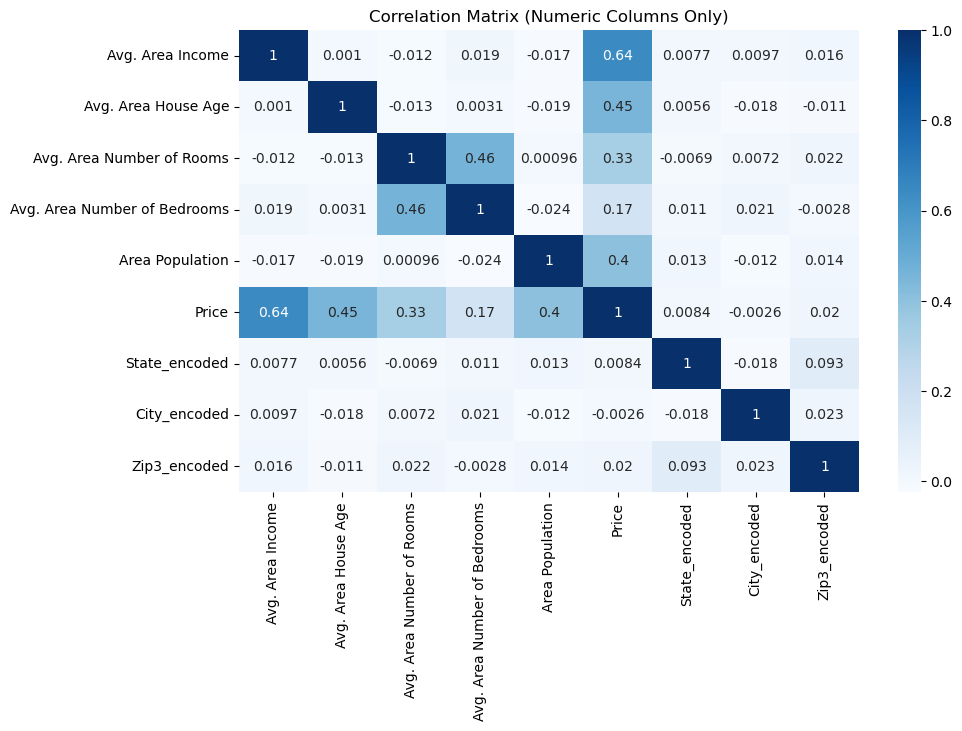


 Pearson Correlation with Price:
Price                           1.000000
Avg. Area Income                0.640103
Avg. Area House Age             0.454224
Area Population                 0.404195
Avg. Area Number of Rooms       0.333597
Avg. Area Number of Bedrooms    0.169230
Zip3_encoded                    0.020237
State_encoded                   0.008444
City_encoded                   -0.002623
Name: Price, dtype: float64

 Feature Importance (Random Forest):
                        Feature  Importance
0              Avg. Area Income    0.427686
1           Avg. Area House Age    0.228364
4               Area Population    0.180431
2     Avg. Area Number of Rooms    0.120283
3  Avg. Area Number of Bedrooms    0.011724
6                  City_encoded    0.011313
7                  Zip3_encoded    0.010398
5                 State_encoded    0.009801


/tmp/ipykernel_41091/376154865.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette="viridis")


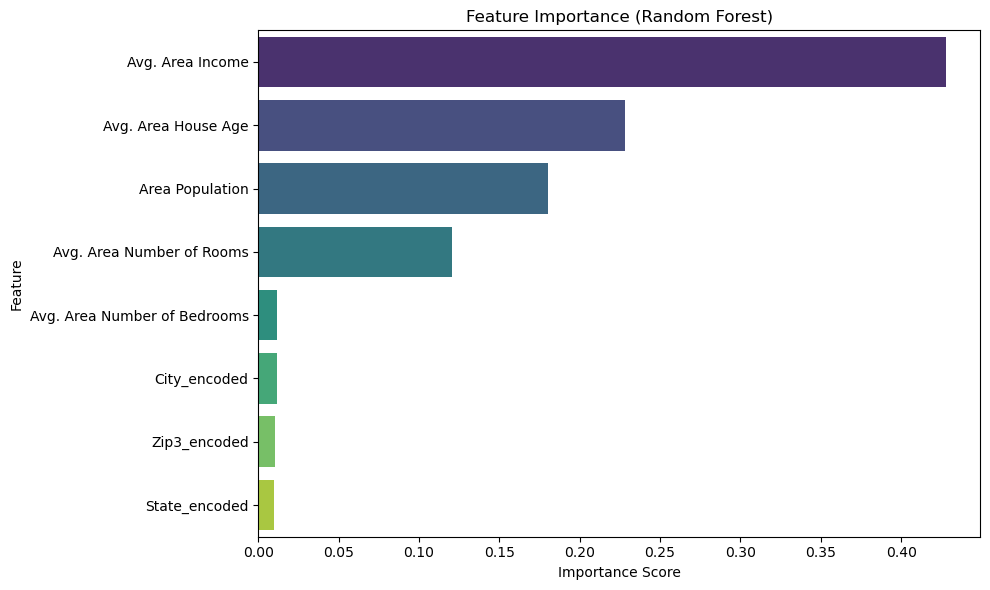

In [45]:

df_numeric = df.select_dtypes(include=['number'])  

correlation = df_numeric.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap="Blues")
plt.title("Correlation Matrix (Numeric Columns Only)")
plt.show()

print("\n Pearson Correlation with Price:")
print(correlation['Price'].sort_values(ascending=False))


y = df['Price']

X = df.select_dtypes(include=['number']).drop(columns=['Price'])

model = RandomForestRegressor(random_state=42)
model.fit(X, y)

importances = model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n Feature Importance (Random Forest):")
print(feature_importance_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette="viridis")
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


# Step Data Transformation

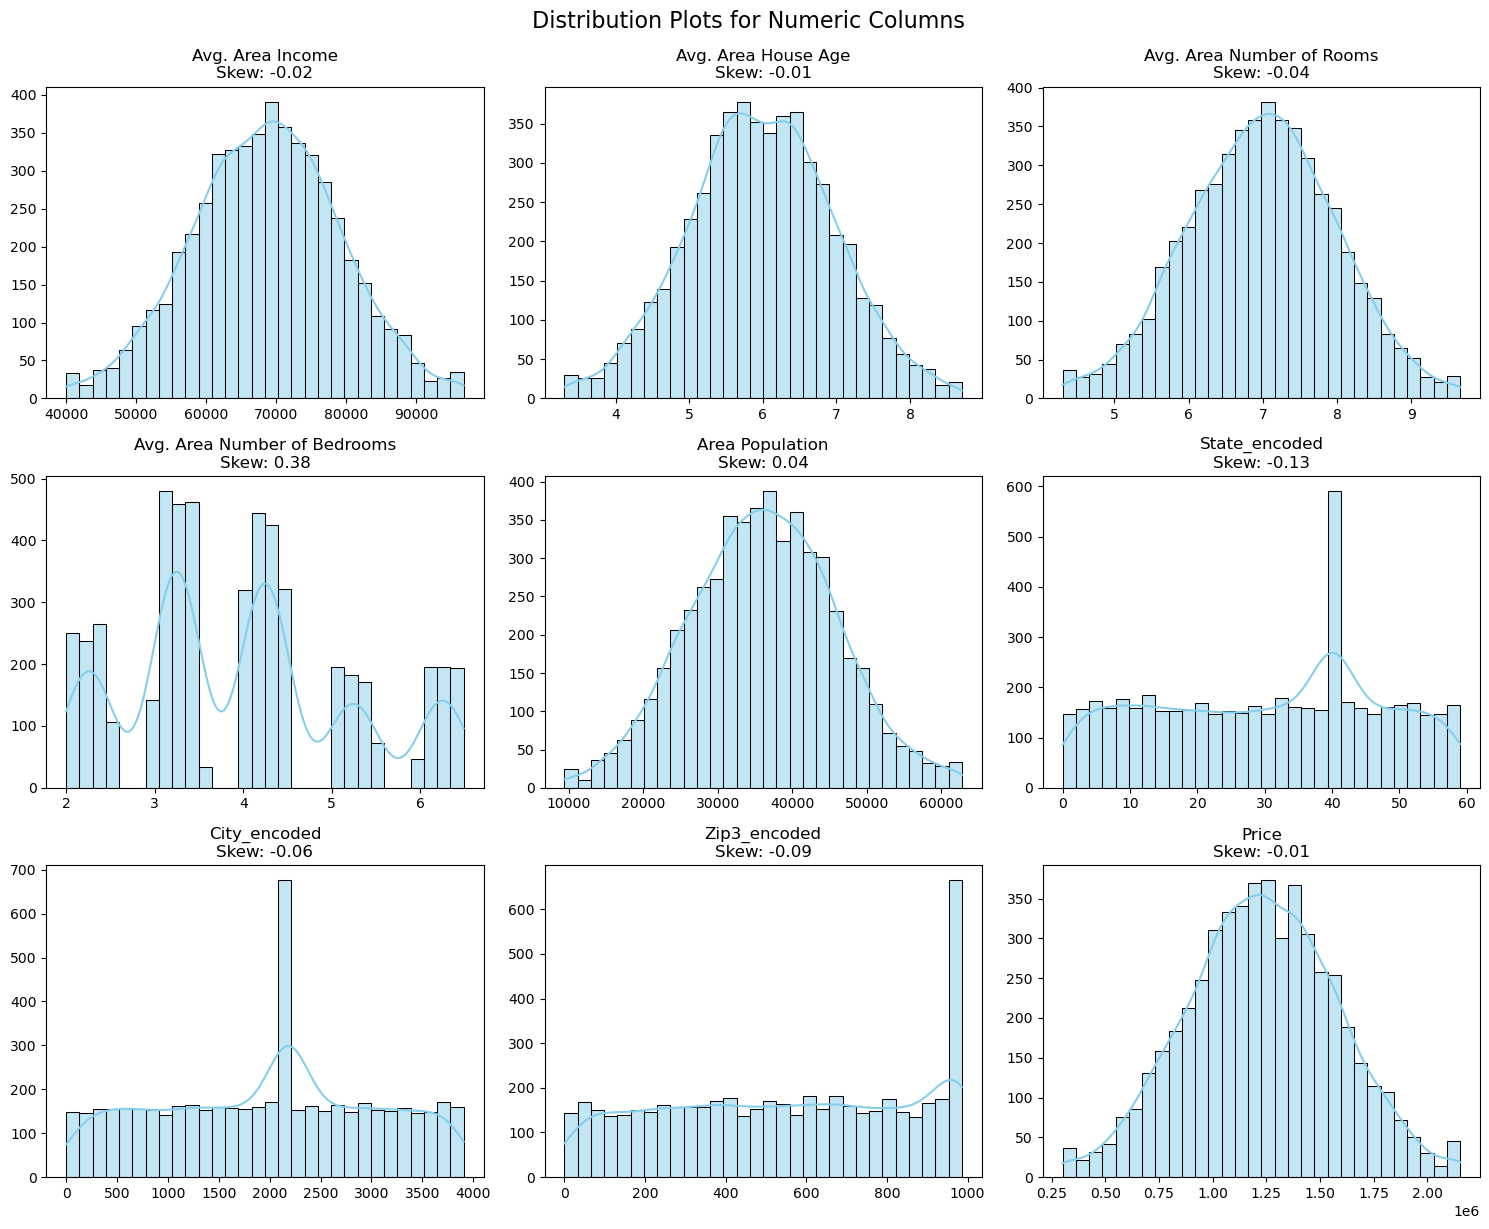

In [13]:

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('Price')

numeric_cols = list(numeric_cols) + ['Price']

cols_per_row = 3
total_cols = len(numeric_cols)
rows = int(np.ceil(total_cols / cols_per_row))

plt.figure(figsize=(cols_per_row * 5, rows * 4))

for i, col in enumerate(numeric_cols):
    plt.subplot(rows, cols_per_row, i + 1)
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f"{col}\nSkew: {df[col].skew():.2f}")
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.suptitle(" Distribution Plots for Numeric Columns", fontsize=16, y=1.02)
plt.show()


# 4.1) Split-out Validation Dataset
Split the dataset into training and validation sets.

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

X = df.select_dtypes(include=['number']).drop(columns=['Price'])
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)




# 4.2) Test Options and Evaluation Metric¶
Define the evaluation metric for the model.

# RandomForestRegressor

In [47]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

selected_features = ["Avg. Area Income", "Avg. Area House Age", "Area Population", "Avg. Area Number of Rooms"]

model = RandomForestRegressor(random_state=42)
model.fit(X_train[selected_features], y_train)

y_pred = model.predict(X_test[selected_features])

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R² Score): {r2:.4f}")



Evaluation Metrics:
Mean Squared Error (MSE): 13072808187.82
R-squared (R² Score): 0.8925


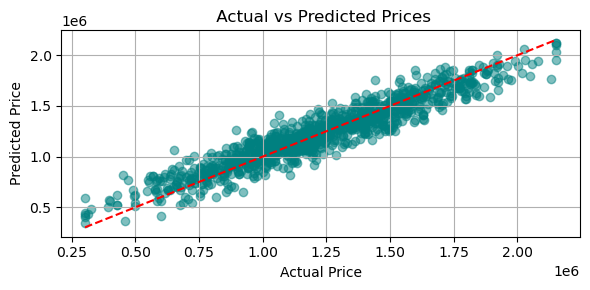

In [48]:

plt.figure(figsize=(6, 3))
plt.scatter(y_test, y_pred, alpha=0.5, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.title(" Actual vs Predicted Prices")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.grid(True)
plt.tight_layout()
plt.show()


# Feature Selection using DecisionTreeRegressor & Training the model with selected features

In [49]:

selected_features = ["Avg. Area Income", "Avg. Area House Age", "Area Population", "Avg. Area Number of Rooms"]

model = DecisionTreeRegressor(random_state=42)
model.fit(X_train[selected_features], y_train)

y_pred = model.predict(X_test[selected_features])

# Evaluation Metrix
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n Evaluation Metrics (Using Selected Features):")
print(f" Mean Squared Error (MSE): {mse:.2f}")
print(f" R-squared (R² Score): {r2:.4f}")



 Evaluation Metrics (Using Selected Features):
 Mean Squared Error (MSE): 28579276240.68
 R-squared (R² Score): 0.7650


# Linear Regresstion >> 


 Evaluation Matrix:
 Mean Squared Error (MSE): 9949107299.67
 R-squared (R²): 0.9182


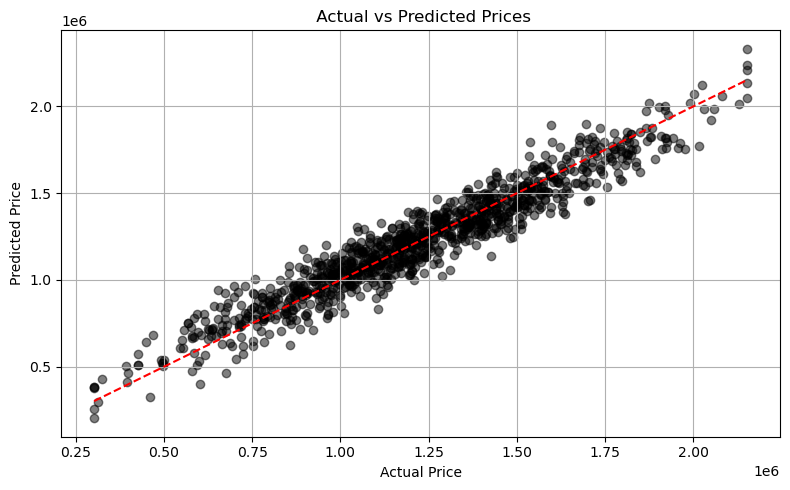

In [50]:
selected_features = ["Avg. Area Income", "Avg. Area House Age", "Area Population", "Avg. Area Number of Rooms"]

model = LinearRegression()
model.fit(X_train[selected_features], y_train)

y_pred = model.predict(X_test[selected_features])

# Define Evaluation Matrix
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n Evaluation Matrix:")
print(f" Mean Squared Error (MSE): {mse:.2f}")
print(f" R-squared (R²): {r2:.4f}")

# Graph to compare the difference between Actual Vs. Prediction Values

plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.5, color='black')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.title(" Actual vs Predicted Prices")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.grid(True)
plt.tight_layout()
plt.show()


# Feature Selection using RFE & Training Linear Regression model with selected features

In [51]:


features = df.select_dtypes(include=['float64', 'int64']).drop(columns=['Price'])
target = df['Price']

#  Data Transformation ,Do scalling ( StandardScaler)
scaler = StandardScaler()
scaled_array = scaler.fit_transform(features)
df_scaled = pd.DataFrame(scaled_array, columns=features.columns)

# 
df_scaled['Price'] = target.values

# 
X = df_scaled.drop(columns=['Price'])
y = df_scaled['Price']

# 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  LinearRegression
lr = LinearRegression()

# Do Feature Selection using RFE (Eg:take 5 feature)
rfe = RFE(estimator=lr, n_features_to_select=5)
rfe.fit(X_train, y_train)

selected_features = X.columns[rfe.support_]
print("Feature Selected From RFE:")
print(selected_features)

# Use the Selection Features Only
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Train The model with Seleced features only
model = LinearRegression()
model.fit(X_train_selected, y_train)

# Prediction
y_pred = model.predict(X_test_selected)
# Define Evaluation Matrix
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n Evaluation Matrix:")
print(f" Mean Squared Error (MSE): {mse:.2f}")
print(f" R-squared (R²): {r2:.4f}")


Feature Selected From RFE:
Index(['Avg. Area Income', 'Avg. Area House Age', 'Avg. Area Number of Rooms',
       'Avg. Area Number of Bedrooms', 'Area Population'],
      dtype='object')

 Evaluation Matrix:
 Mean Squared Error (MSE): 9948245357.80
 R-squared (R²): 0.9182


# Feature Selection using RFE & Training DecisionTreeRegressor model with selected features

In [52]:


features = df.select_dtypes(include=['float64', 'int64']).drop(columns=['Price'])
target = df['Price']

#  Data Transformation ,Do scalling ( StandardScaler)
scaler = StandardScaler()
scaled_array = scaler.fit_transform(features)
df_scaled = pd.DataFrame(scaled_array, columns=features.columns)

# 
df_scaled['Price'] = target.values

# 
X = df_scaled.drop(columns=['Price'])
y = df_scaled['Price']

# 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  DecisionTreeRegressor
dt = DecisionTreeRegressor(random_state=42)

# Do Feature Selection using RFE (Eg:take 5 feature)
rfe = RFE(estimator=dt, n_features_to_select=5)
rfe.fit(X_train, y_train)

selected_features = X.columns[rfe.support_]
print("Feature Selected From RFE:")
print(selected_features)

# Use the Selection Features Only
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Train The model with Seleced features only
model =  DecisionTreeRegressor(random_state=42)
model.fit(X_train_selected, y_train)

# Prediction
y_pred = model.predict(X_test_selected)
# Define Evaluation Matrix
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n Evaluation Matrix:")
print(f" Mean Squared Error (MSE): {mse:.2f}")
print(f" R-squared (R²): {r2:.4f}")




Feature Selected From RFE:
Index(['Avg. Area Income', 'Avg. Area House Age', 'Avg. Area Number of Rooms',
       'Area Population', 'City_encoded'],
      dtype='object')

 Evaluation Matrix:
 Mean Squared Error (MSE): 28796350866.09
 R-squared (R²): 0.7632


# Feature Selection using RFE & Training RandomForestRegressor model with selected features

In [53]:

features = df.select_dtypes(include=['float64', 'int64']).drop(columns=['Price'])
target = df['Price']

#  Data Transformation ,Do scalling ( StandardScaler)
scaler = StandardScaler()
scaled_array = scaler.fit_transform(features)
df_scaled = pd.DataFrame(scaled_array, columns=features.columns)

# 
df_scaled['Price'] = target.values

# 
X = df_scaled.drop(columns=['Price'])
y = df_scaled['Price']

# 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  RandomForestRegressor
rf =RandomForestRegressor(random_state=42)

# Do Feature Selection using RFE (Eg:take 5 feature)
rfe = RFE(estimator=rf, n_features_to_select=5)
rfe.fit(X_train, y_train)

selected_features = X.columns[rfe.support_]
print("Feature Selected From RFE:")
print(selected_features)

# Use the Selection Features Only
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Train The model with Seleced features only
model = RandomForestRegressor(random_state=42)
model.fit(X_train_selected, y_train)

# Prediction
y_pred = model.predict(X_test_selected)
# Define Evaluation Matrix
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n Evaluation Matrix:")
print(f" Mean Squared Error (MSE): {mse:.2f}")
print(f" R-squared (R²): {r2:.4f}")



Feature Selected From RFE:
Index(['Avg. Area Income', 'Avg. Area House Age', 'Avg. Area Number of Rooms',
       'Area Population', 'City_encoded'],
      dtype='object')

 Evaluation Matrix:
 Mean Squared Error (MSE): 13167597499.22
 R-squared (R²): 0.8917


# HuperParameter Tuning For RandomForestRegessor Using GridSearchCV

In [56]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score


selected_features = ["Avg. Area Income", "Avg. Area House Age", "Area Population", "Avg. Area Number of Rooms"]

param_grid = {
    'n_estimators': [50, 100, 200],          
    'max_depth': [None, 10, 20],             
    'min_samples_split': [2, 5],           
    'min_samples_leaf': [1, 2]               
}

rf = RandomForestRegressor(random_state=42)

# Optimize Hyperparameter Using GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train[selected_features], y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test[selected_features])

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("(Hyperparameters):")
print(grid_search.best_params_)

print("\n :")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R²): {r2:.4f}")


(Hyperparameters):
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

 :
Mean Squared Error (MSE): 13064053576.51
R-squared (R²): 0.8926


# HuperParameter Tuning For DecisionTreeRegressor Using GridSearchCV

In [57]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

selected_features = ["Avg. Area Income", "Avg. Area House Age", "Area Population", "Avg. Area Number of Rooms"]

param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt = DecisionTreeRegressor(random_state=42)

grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train[selected_features], y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test[selected_features])

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("(Hyperparameters):")
print(grid_search.best_params_)

print("\n :")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R²): {r2:.4f}")


(Hyperparameters):
{'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}

 :
Mean Squared Error (MSE): 23490386095.57
R-squared (R²): 0.8068


In [64]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

selected_features = ["Avg. Area Income", "Avg. Area House Age", "Area Population", "Avg. Area Number of Rooms"]

param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10, 100]
}

ridge = Ridge()
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train[selected_features], y_train)

best_ridge = grid_search.best_estimator_

y_pred = best_ridge.predict(X_test[selected_features])

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 
print(" best alpha value:", grid_search.best_params_)
print(f" MSE : {mse:.2f}")
print(f" R²: {r2:.4f}")


 best alpha value: {'alpha': 0.1}
 MSE : 9949163239.77
 R²: 0.9182


# Ensembles¶
Combine multiple models to improve accuracy.

# VotingRegressor

In [62]:
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score

selected_features = ["Avg. Area Income", "Avg. Area House Age", "Area Population", "Avg. Area Number of Rooms"]

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# 1. Ridge Regression (with best alpha)
ridge = Ridge(alpha=0.1)

# 2. Random Forest (with best hyperparameters)
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# 3. Decision Tree (with best hyperparameters)
dt = DecisionTreeRegressor(
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42
)

#  Voting Regressor
ensemble_model = VotingRegressor(estimators=[
    ('ridge', ridge),
    ('random_forest', rf),
    ('decision_tree', dt)
])

#
ensemble_model.fit(X_train[selected_features], y_train)

# 
y_pred = ensemble_model.predict(X_test[selected_features])

# 
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n Ensemble Model Results:")
print(f" Mean Squared Error (MSE): {mse:.2f}")
print(f" R-squared (R²): {r2:.4f}")



 Ensemble Model Results:
 Mean Squared Error (MSE): 12604692649.25
 R-squared (R²): 0.8963


# Stacking Regressor

In [63]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

selected_features = ["Avg. Area Income", "Avg. Area House Age", "Area Population", "Avg. Area Number of Rooms"]

#   (Base Models)
base_models = [
    ('ridge', Ridge(alpha=0.1)),
    ('random_forest', RandomForestRegressor(
        n_estimators=200, max_depth=20, min_samples_split=2, min_samples_leaf=1, random_state=42)),
    ('decision_tree', DecisionTreeRegressor(
        max_depth=None, min_samples_split=10, min_samples_leaf=4, random_state=42))
]

#  (Meta-model)
meta_model = LinearRegression()

# build Stacking Regressor
stack_model = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    passthrough=True,        
    cv=5,              
    n_jobs=-1
)

# 
stack_model.fit(X_train[selected_features], y_train)

# 
y_pred = stack_model.predict(X_test[selected_features])

# 
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 
print("\n Stacking Regressor Results:")
print(f" Mean Squared Error (MSE): {mse:.2f}")
print(f" R-squared (R²): {r2:.4f}")




 Stacking Regressor Results:
 Mean Squared Error (MSE): 9952347018.96
 R-squared (R²): 0.9181


# Predictions on Validation Dataset
Make predictions using the validation dataset.

In [68]:

# Prediction (Validation Set)
y_pred = stack_model.predict(X_test[selected_features])

comparison_df = pd.DataFrame({
    'Actual Price': y_test.values,
    'Predicted Price': y_pred
})

print("\n Comparision between Actual Price & predicted Price:")
print(comparison_df.head(10))



 Comparision between Actual Price & predicted Price:
   Actual Price  Predicted Price
0  9.053288e+05     8.041729e+05
1  1.204598e+06     1.337689e+06
2  6.133709e+05     8.024333e+05
3  1.222690e+06     1.321923e+06
4  7.966661e+05     6.868070e+05
5  1.205879e+06     1.380704e+06
6  9.850070e+05     9.815673e+05
7  1.850514e+06     1.618841e+06
8  1.115935e+06     9.719037e+05
9  1.059114e+06     1.142946e+06


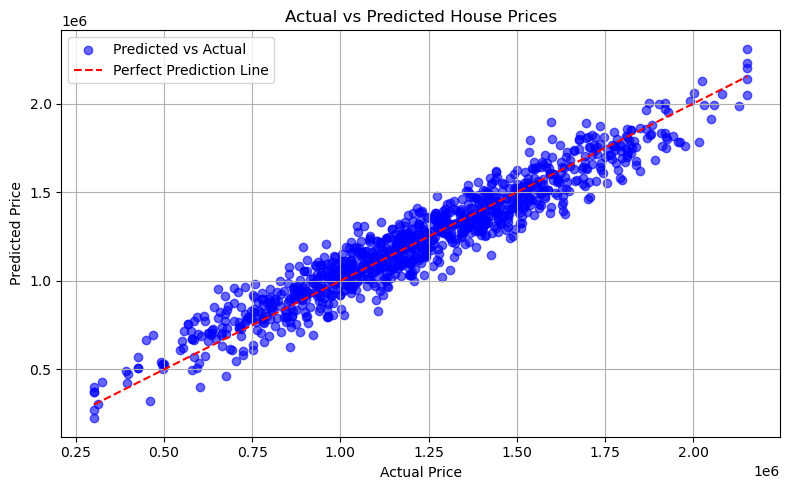

In [69]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', label='Perfect Prediction Line')

plt.title("Actual vs Predicted House Prices")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
